###
## Phase Neural Operator (PhaseNO)
### PhaseNO for multi-station earthquake detection and phase picking
### - Predict on continuous seismic data with the pretrained model - 

##### Author: Hongyu Sun
##### Email: hongyu-sun@outlook.com

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'


import numpy as np
import pandas as pd

import random; random.seed(10)
import obspy
from tqdm import tqdm
from datetime import datetime
from collections import namedtuple

import matplotlib.pyplot as plt
import matplotlib
font = {'weight' : 'bold',
        'size'   : 12}
matplotlib.rc('font', **font)

from PhaseNO import PhaseNO
from PhaseNO.processing import trim_nan, detect_peaks, save_picks_json, extract_amplitude
from PhaseNO.utilities import (
    generate_edge_index,
    generate_knn_edge_index,
    generate_radius_edge_index
)

import torch
import torch_geometric
from torch.profiler import profile, record_function, ProfilerActivity

#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

device = torch.device("cpu")


### set station information: path and center
#### Important! modify "center" to the correct center of your seismic networks

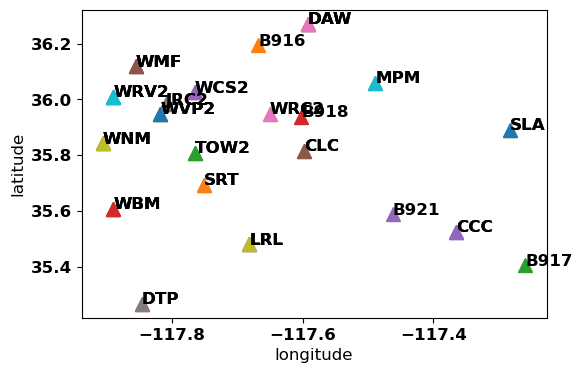

In [6]:
stations_new = pd.read_csv('../example/stations.csv',sep=',')
center = (-117.6, 35.8) ## Modify here according to your stations
x_min, y_min = center[0] - 1, center[1] - 1

PLOT = 1

def plot_stations(stations_new):
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    for i,sta in enumerate(stations_new['station']):
        ax.plot(stations_new['longitude'][i],stations_new['latitude'][i],'^',markersize=10)
        ax.text(stations_new['longitude'][i],stations_new['latitude'][i],sta)

    ax.locator_params(axis='both', nbins=6)
    ax.set_xlabel('longitude')
    ax.set_ylabel('latitude')
    # ax.set_xlim(x_min, x_min+2);
    # ax.set_ylim(y_min, y_min+2)

if PLOT == 1:
    plot_stations(stations_new)

In [7]:
stations_new

,id,network,station,channel,latitude,longitude,unit,component,response
0,CI.CCC..HN,CI,CCC,HN,35.525,-117.365,m/s**2,"E,N,Z","213979.00,214322.00,213808.00"
1,CI.CLC..HN,CI,CLC,HN,35.816,-117.598,m/s**2,"E,N,Z","213945.00,213808.00,213740.00"
2,CI.DAW..HN,CI,DAW,HN,36.271,-117.592,m/s**2,"E,N,Z","213512.00,213897.00,214625.00"
3,CI.DAW.2C.HN,CI,DAW,HN,36.271,-117.592,m/s**2,"E,N,Z","213349.00,213734.00,214461.00"
4,CI.JRC2..HN,CI,JRC2,HN,35.982,-117.809,m/s**2,"E,N,Z","213808.00,213945.00,214185.00"
5,CI.LRL..HN,CI,LRL,HN,35.480,-117.682,m/s**2,"E,N,Z","213757.00,213671.00,213201.00"
6,CI.LRL.2C.HN,CI,LRL,HN,35.480,-117.682,m/s**2,"E,N,Z","213757.00,213671.00,213201.00"
7,CI.MPM..HN,CI,MPM,HN,36.058,-117.489,m/s**2,"E,N,Z","213911.00,214219.00,213911.00"
8,CI.SLA..HN,CI,SLA,HN,35.891,-117.283,m/s**2,"E,N,Z","214253.00,213671.00,213979.00"
9,CI.SRT..HN,CI,SRT,HN,35.692,-117.751,m/s**2,"E,N,Z","214301.00,213873.00,214087.00"


### load trained PhaseNO model

In [3]:
model = PhaseNO.load_from_checkpoint('../models/epoch=19-step=1140000.ckpt', map_location=device)#.to(device)
model.eval();

Lightning automatically upgraded your loaded checkpoint from v1.9.0 to v2.1.3. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../models/epoch=19-step=1140000.ckpt`


### Set data path and parameters here

In [9]:
Data_Path   = '../example/waveforms' # folder contains raw data

PROB = 1 # use 1 if you want to output predicted probability time series and then plotting with phaseno_plot.ipynb
# consider PROB = 0 to save storage if processing a large amount of data
PICK = 1 # use 1 to output picks using a pikcing threshold (default threshold is 0.3)

if PROB == 1:
    output_name = '../example/results/probability'
    prob_dir = os.path.join(output_name)
    if not os.path.exists(prob_dir):
        os.makedirs(prob_dir)

if PICK == 1:
    result_name = '../example/results/picks'
    result_dir = os.path.join(result_name)
    if not os.path.exists(result_dir):
        os.makedirs(result_dir)

timestamp = datetime(2019, 7, 6, 8, 0)
timeend   = datetime(2019, 7, 6, 9, 0) # end time of all data (not included)
threshold = 0.3 # probability threshold for picking
in_samples = 3000 # time window is 30 s in a run
overlap = 1000 # use a 10-s overlap between two time windows
steps = in_samples - overlap
sample_rate = 100
highpass_filter = 1 # Hz
eps = 1e-6
dtype = 'float32'
n_channel = 3
n_neighbors = 6 # number of neighbors for the knn graph
radius = 0.2 # neighbor radius for radius graph

In [10]:
def get_picks_and_amps(stations, num_station, pred_merge):
    p_idx, p_prob, s_idx, s_prob = [], [], [], []
    picks_part_stations = []
    picks_all_stations = []
    amps_all_stations = []

    for k in range(num_station):
        id = fname[k]
        sta = stations[k]
        pred = np.nanmean(pred_merge[k], axis=-1)
        P_seq, _, _ = trim_nan(pred[0])
        S_seq, _, _ = trim_nan(pred[1])
        p, p_pro = detect_peaks(P_seq[:360000], mph=threshold, mpd=1.0*sample_rate)
        s, s_pro = detect_peaks(S_seq[:360000], mph=threshold, mpd=1.0*sample_rate)

        picks_part_stations.append(record(id, sta, t0, list(p), list(p_pro), list(s), list(s_pro)))

    amps_part_stations = extract_amplitude(data_raw, picks_part_stations, window_p=8, window_s=4, dt=1/sample_rate)

    picks_all_stations += picks_part_stations
    amps_all_stations += amps_part_stations

    return picks_all_stations, amps_all_stations

def probs_to_stream(num_station, pred_merge, trace_stats):
    for k in range(num_station):

        #id = fname[k]
        output = obspy.Stream()
        pred = np.nanmean(pred_merge[k], axis=-1)

        for i in range(2):

            trimmed_pred, f, _ = trim_nan(pred[i])
            trimmed_start = trace_stats[k].starttime + f / sample_rate

            output.append(
                obspy.Trace(
                    trimmed_pred,
                    {
                        "starttime": trimmed_start,
                        "sampling_rate": sample_rate,
                        "network": trace_stats[k].network,
                        "station": trace_stats[k].station,
                        "location": trace_stats[k].location,
                        "channel": label_name[i],
                    },
                )
            )
    return output

### Set up station dataframe

In [11]:
label_name=["P_Prob","S_Prob"]
record = namedtuple("phase", ["fname", "station_id", "t0", "p_idx", "p_prob", "s_idx", "s_prob"])

picks_all_stations = []
amps_all_stations  = []

itime = timestamp.strftime("%Y-%m-%dT%H:%M")
print('current at', itime)

# create list of channels from waveform filenames := station_all
station_all = []
for fname in os.listdir(Data_Path):# The list is in arbitrary order
    if itime in fname:
        channel_name = fname.split('.')[2]
        station_name = fname.split('.')[1]
        network_name = fname.split('.')[0]
        station_all.append(network_name+'.'+station_name+'.'+channel_name)

print('number of stations at ', itime, ': ', len(station_all))

# run model on subnetworks since doing on fully connected graph is too slow

# use all stations

station_select = station_all

print('selected stations: ', station_select)

# construct dataframe for the network
networks = []
stations = []
channels = []
ids = []
comps = []
ress = []
units = []
latitude = []
longitude = []
for sta in station_select:
    ch = sta.split('.')[-1]
    st = sta.split('.')[1]
    ne = sta.split('.')[0]
    channels.append(ch)
    stations.append(st)
    networks.append(ne)
    temp = stations_new.loc[stations_new['station'] == st]
    sta_select = temp.loc[temp['channel'] == ch]
    ids.append(sta_select.iloc[0]['id'])
    comps.append(sta_select.iloc[0]['component'])
    ress.append(sta_select.iloc[0]['response'])
    units.append(sta_select.iloc[0]['unit'])
    latitude.append(sta_select.iloc[0]['latitude'])
    longitude.append(sta_select.iloc[0]['longitude'])

df = pd.DataFrame(
    data={
        'id': ids,
        'network': networks,
        'station': stations,
        'channel': channels,
        'component': comps,
        'response': ress,
        'unit': units,
        'latitude': latitude,
        'longitude': longitude
    }
)

num_station = len(stations)

current at 2019-07-06T08:00
number of stations at  2019-07-06T08:00 :  36
selected stations:  ['CI.DAW.HN', 'CI.MPM.HN', 'CI.WRV2.HN', 'PB.B916.EH', 'CI.WMF.HN', 'CI.WBM.HN', 'CI.LRL.HH', 'CI.SLA.HN', 'CI.MPM.HH', 'CI.WNM.EH', 'CI.SRT.HN', 'CI.WRV2.EH', 'CI.JRC2.HH', 'CI.SRT.HH', 'CI.WVP2.HN', 'CI.WVP2.EH', 'CI.CCC.HH', 'CI.WCS2.HH', 'PB.B917.EH', 'CI.WRC2.HH', 'CI.WNM.HN', 'CI.CCC.HN', 'CI.LRL.HN', 'CI.WMF.HH', 'CI.CLC.HH', 'CI.CLC.HN', 'CI.WBM.HH', 'CI.TOW2.HH', 'CI.WRC2.HN', 'CI.SLA.HH', 'CI.TOW2.HN', 'PB.B921.EH', 'PB.B918.EH', 'CI.DAW.HH', 'CI.WCS2.HN', 'CI.JRC2.HN']


In [13]:
df

,id,network,station,channel,component,response,unit,latitude,longitude
0,CI.DAW..HN,CI,DAW,HN,"E,N,Z","213512.00,213897.00,214625.00",m/s**2,36.271,-117.592
1,CI.MPM..HN,CI,MPM,HN,"E,N,Z","213911.00,214219.00,213911.00",m/s**2,36.058,-117.489
2,CI.WRV2..HN,CI,WRV2,HN,"E,N,Z","213883.00,235224.00,235139.00",m/s**2,36.008,-117.890
3,PB.B916..EH,PB,B916,EH,"1,2,Z","781398000.00,781398000.00,781398000.00",m/s,36.193,-117.668
4,CI.WMF..HN,CI,WMF,HN,"E,N,Z","214087.00,214087.00,214087.00",m/s**2,36.118,-117.855
5,CI.WBM..HN,CI,WBM,HN,"E,N,Z","213550.00,214064.00,213550.00",m/s**2,35.608,-117.890
6,CI.LRL..HH,CI,LRL,HH,"E,N,Z","628306000.00,629984000.00,627467000.00",m/s,35.480,-117.682
7,CI.SLA..HN,CI,SLA,HN,"E,N,Z","214253.00,213671.00,213979.00",m/s**2,35.891,-117.283
8,CI.MPM..HH,CI,MPM,HH,"E,N,Z","627368000.00,627368000.00,627368000.00",m/s,36.058,-117.489
9,CI.WNM..EH,CI,WNM,EH,Z,69306200.00,m/s,35.842,-117.906


In [14]:
df.to_csv("network.csv")

### create the edge index for the subnetwork

In [10]:
#edge_index, station_convert = generate_edge_index(df) 
edge_index, station_convert = generate_knn_edge_index(df, n_neighbors)
edge_index = edge_index.to(device)

### Load waveforms

In [11]:
picks_select_stations = []
print('------------------------ reading waveforms ------------------------')

fname = []
bg_st=obspy.core.Stream()
for net,sta,cha in tqdm(zip(df['network'],df['station'],df['channel'])):

    fname.append(net+'.'+sta+'.'+cha+'.'+itime+'.mseed')
    mseed = obspy.read(os.path.join(Data_Path,net+'.'+sta+'.'+cha+'.'+itime+'.mseed'))
    #mseed = mseed.detrend("spline", order=2, dspline=5 * mseed[0].stats.sampling_rate)

    # for trace in mseed:  # if the sampling rate in downloaded data is a float closed to 100.0, e.g., 99.99
    #     trace.stats.sampling_rate = 100.0
    mseed = mseed.merge(fill_value="latest")
    mseed = mseed.detrend("demean")

    if highpass_filter > 0:
        mseed = mseed.filter("highpass", freq=highpass_filter)

    if len(mseed) < 3:
        for r in np.arange(3-len(mseed)):
            mseed.append(mseed[0])

    bg_st += mseed[:3]

starttime = min([st.stats.starttime for st in bg_st])
endtime = max([st.stats.endtime for st in bg_st])
bg_st = bg_st.trim(starttime, endtime, pad=True, fill_value=0)
split_points=list(range(3,len(bg_st),3))

##### process raw amplitude for magnitude estimation #####

nt = len(bg_st[0].data)
raw_amp = []
for ista in range(num_station):
    trace_amp = np.zeros([nt, n_channel], dtype=dtype)
    id = df.iloc[ista]["id"]
    comp = df.iloc[ista]["component"].split(",")
    #resp = df.iloc[ista]["response"].split(",")

    for ich in np.arange(n_channel):
        ii = ista*n_channel+ich
        ## accerleration to velocity
        if df.iloc[ista]["unit"] == "m/s**2":
            bg_st[ii] = bg_st[ii].integrate().filter("highpass", freq=highpass_filter)

        tmp = bg_st[ii].data.astype(dtype)

        trace_amp[:, ich] = tmp[:nt]

    raw_amp.append(trace_amp)

raw_amp_temp = np.transpose(np.concatenate(raw_amp, axis=1))
data_raw  = np.split(raw_amp_temp[:,:360000],split_points)

preds = []
starts = []
trace_stats=[]
for ii in list(range(0,len(bg_st),3)):
    tr = bg_st[ii]
    trace_stats.append(tr.stats)

starttime = min([st.starttime for st in trace_stats])
t0 = starttime.strftime("%Y-%m-%dT%H:%M:%S.%f")[:-3]
print('t0=', t0)


------------------------ reading waveforms ------------------------


36it [00:48,  1.34s/it]


t0= 2019-07-06T07:59:59.988


In [17]:
df

,id,network,station,channel,component,response,unit,latitude,longitude


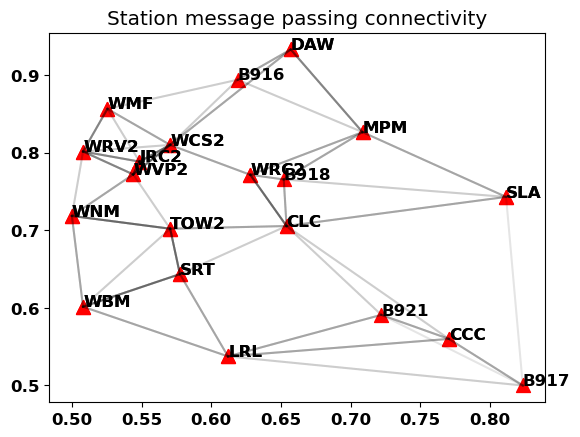

In [9]:
for pair in edge_index.T:
    v1, v2, v1x, v1y, v2x, v2y = pair.cpu()
    plt.plot((v1x, v2x), (v1y, v2y), "k", alpha=0.1)

for i,(x,y) in enumerate(station_convert):
    plt.scatter(x, y, marker="^", s=100, color="red", alpha=1)
    plt.text(x, y, df.iloc[i].station)

plt.title("Station message passing connectivity");


### Predictions

In [10]:
# What is needed for the predictions only?
# data tensor 'X' and edge_index

# loop over windows, normalize, construct X tensor, and predict
for index, windowed_st in enumerate(tqdm(bg_st.slide(window_length=in_samples/sample_rate, step=steps/100.0,include_partial_windows=True))):
    s = index * steps # windowed_st[0].stats.starttime
    if len(windowed_st)!=len(bg_st):
        print('skip')
        preds.append(np.zeros((num_station,2,in_samples)))
        starts.append(s)
        continue
    start_trim = min([tr.stats.starttime for tr in windowed_st])
    end_trim = max([tr.stats.endtime for tr in windowed_st])
    windowed_st.trim(start_trim, max(start_trim+in_samples/sample_rate, end_trim) , pad=True, fill_value=0)
    temp = np.array(windowed_st)[:,-in_samples:]
    temp = np.split(temp,split_points)
    temp = np.array(temp,dtype=float)

    temp_mean = np.mean(temp,axis=-1,keepdims=True)
    temp_std  = np.std(temp,axis=-1,keepdims=True)
    temp_ = (temp-temp_mean)/(temp_std+eps)

    # What is X?? - (num_station x 5 x nsamples) tensor
    # station index, [E trace, N trace, Z trace, latitude, longitude], samples

    X = np.zeros((num_station, 3+2, in_samples))
    X[:,:3,:] = temp_/10

    for istation in np.arange(num_station):
        X[istation,3,:] = station_convert[istation,0]
        X[istation,4,:] = station_convert[istation,1]

    X = torch.tensor(X, dtype=torch.float)
    X = X.to(device)
    res=torch.sigmoid(model.forward((X,None,edge_index)))
    preds.append(res.cpu().detach().numpy())
    starts.append(s)

180it [10:16,  3.43s/it]


### postprocessing

In [19]:

print('------------------------ start post-processing ------------------------')

prediction_sample_factor=1
# Maximum number of predictions covering a point
coverage = int(
    np.ceil(in_samples / (in_samples - overlap) + 1)
)

pred_length = int(
    np.ceil(
        (np.max(starts)+in_samples) * prediction_sample_factor
    )
)
pred_merge = (
    np.zeros_like(
        preds[0], shape=( preds[0].shape[0],preds[0].shape[1], pred_length, coverage)
    )
    * np.nan
)

for i, (pred, start) in enumerate(zip(preds, starts)):
                pred_start = int(start * prediction_sample_factor)
                pred_merge[
                    :,:, pred_start : pred_start + pred.shape[2], i % coverage
                ] = pred

if PICK == 1:
    picks_all_stations, amps_all_stations = get_picks_and_amps(stations, num_station, pred_merge)

if PROB == 1:
    output = probs_to_stream(num_station, pred_merge, trace_stats)


------------------------ start post-processing ------------------------


### Run the following to save picks and probs

In [17]:
if PICK == 1:
    save_picks_json(picks_all_stations, result_dir, dt=1/sample_rate, amps=amps_all_stations,fname='picks_'+itime+'.json')

if PROB == 1:
    output.write(os.path.join(prob_dir, trace_stats[k].network+'.'+trace_stats[k].station+'.'+channels[k]+'.'+itime+'.mseed'), format='MSEED')


## Check the wrapper function

In [82]:
from PhaseNO import PhaseNOPredictor

In [164]:
predictor = PhaseNOPredictor(df, graph_type="knn", k=10)

Lightning automatically upgraded your loaded checkpoint from v1.9.0 to v2.1.3. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../models/epoch=19-step=1140000.ckpt`


In [258]:
data = np.stack([tr.data[:5999] for tr in bg_st])
data = data.reshape((108//3, 3,-1))
data.shape

(36, 3, 5999)

In [259]:
with torch.no_grad():
    preds = predictor(data)

reshaped and padded torch.Size([4, 36, 3, 3000])
torch.Size([4, 36, 5, 3000])
first
torch.Size([36, 2, 3000])
number 2
torch.Size([36, 2, 5000])
number 3
torch.Size([36, 2, 7000])
number 4
torch.Size([36, 2, 9000])


In [260]:
preds.shape

torch.Size([36, 2, 5999])

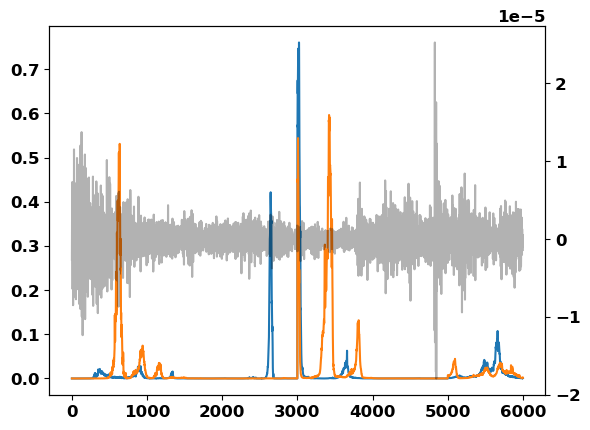

In [261]:
plt.plot(preds[2,0])
plt.plot(preds[2,1])
ax2 = plt.gca().twinx()

ax2.plot(data[0,2],"k", alpha=0.3)

In [203]:
predictor.pad_length

0

In [3]:
stations_new

NameError: name 'stations_new' is not defined

In [2]:
import obspy

In [ ]:
obspy.get_station(